In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math
import numpy as np
import datetime
from functools import reduce
from matplotlib import pyplot as plt
from soccerlearn.features import *
    
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


SMALL_SIZE=17
MEDIUM_SIZE=SMALL_SIZE+5
BIGGER_SIZE=MEDIUM_SIZE+5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=200)


In [2]:
fixtures_and_odds = pd.read_csv('../data/fixtures_and_odds_La Liga_2014-07-01_2020-07-01.csv')
season_data = pd.read_csv('../data/seasons.csv').rename(columns={'id': 'season_id', 'name': 'season_name'})
fixtures_and_odds = pd.merge(fixtures_and_odds, season_data[['season_id', 'season_name']], on='season_id', how='left')
fixtures_and_odds['season_start_year'] = fixtures_and_odds['season_name'].apply(lambda x: x.split('/')[0])
fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
fixtures_and_odds['year'] = fixtures_and_odds['date_time'].dt.year
fixtures_and_odds['month'] = fixtures_and_odds['date_time'].dt.month
fixtures_and_odds['date'] = fixtures_and_odds['date_time'].dt.date
fixtures_and_odds['round_id'] = fixtures_and_odds['round_id'].apply(lambda x: np.nan if math.isnan(x) else str(int(x)))
date_to_season = fixtures_and_odds.groupby('date')[['season_id']].first()
standings_data = pd.read_csv('../data/standings_La Liga.csv')
data = {'fixtures': fixtures_and_odds, 'standings': standings_data}
data['fixtures'] = unpivot_fixtures_by_odds(data)

pipeline =  Pipeline([
    ('pivot_fixtures_by_team', pivot_fixtures_by_team, {}),
    ('get_scores', get_scores, {}),
    ('get_results', get_results, {}),
    ('get_games_played', get_games_played_current_season, {}),
    ('get_cumulative_results', get_cumulative_results_current_season, {}),
    ('get_winning_odds', get_winning_odds, {}),
])
fixture_features = pipeline.transform(data)
teams = pd.read_csv('../data/teams_league_La Liga.csv').rename(columns={'id': 'team_id'}).groupby('team_id')[['name', 'short_code']].first()

fixture_features = fixture_features.join(teams, how='outer')
fixture_features = pd.merge(fixture_features, compute_position_end_season(data), left_on=['season_id', 'team_id'], right_index=True, how='left')
data = {'fixture_features': fixture_features}
fixture_features = pd.merge(data['fixture_features'], compute_previous_season_features(data), left_on=['season_start_year', 'team_id'], right_index=True, how='left')
print(fixture_features.shape)
fixture_features.head()

Creating feature pivot_fixtures_by_team
Creating feature get_scores
Creating feature get_results
Creating feature get_games_played
Creating feature get_cumulative_results
Creating feature get_winning_odds
(4560, 34)


round_id  \
team_id date                  
36      2014-08-24    54887   
        2014-08-30    54895   
        2014-09-13    54903   
        2014-09-20    54911   
        2014-09-23    54921   

                                                               scores  \
team_id date                                                            
36      2014-08-24  {'localteam_score': 3, 'visitorteam_score': 1,...   
        2014-08-30  {'localteam_score': 1, 'visitorteam_score': 1,...   
        2014-09-13  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-20  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-23  {'localteam_score': 2, 'visitorteam_score': 1,...   

                    winner_team_id  season_id season_start_year  \
team_id date                                                      
36      2014-08-24            36.0       2061              2014   
        2014-08-30             NaN       2061              2014   
        2014-09-13             NaN       2061              2014   
        2014-09-20             NaN       2061              2014   
        2014-09-23            36.0       2061              2014   

                    winning_odds_calculated  odd_value_1  odd_value_2  \
team_id date                                                            
36      2014-08-24                     True          NaN          NaN   
        2014-08-30                     True          NaN          NaN   
        2014-09-13                     True          NaN          NaN   
        2014-09-20                     True          NaN          NaN   
        2014-09-23                     True          NaN          NaN   

                    odd_value_X  odd_winning_1  ...  \
team_id date                                    ...   
36      2014-08-24          NaN            NaN  ...   
        2014-08-30          NaN            NaN  ...   
        2014-09-13          NaN            NaN  ...   
        2014-09-20          NaN            NaN  ...   
        2014-09-23          NaN            NaN  ...   

                    goals_conceded_current_season  points_current_season  \
team_id date                                                               
36      2014-08-24                              1                      3   
        2014-08-30                              2                      4   
        2014-09-13                              4                      5   
        2014-09-20                              6                      6   
        2014-09-23                              7                      9   

                    winning_odds           name  short_code  \
team_id date                                                  
36      2014-08-24           NaN  Celta de Vigo         CLV   
        2014-08-30           NaN  Celta de Vigo         CLV   
        2014-09-13           NaN  Celta de Vigo         CLV   
        2014-09-20           NaN  Celta de Vigo         CLV   
        2014-09-23           NaN  Celta de Vigo         CLV   

                   position_end_season  position_end_season_lag_1  \
team_id date                                                        
36      2014-08-24                   8                        NaN   
        2014-08-30                   8                        NaN   
        2014-09-13                   8                        NaN   
        2014-09-20                   8                        NaN   
        2014-09-23                   8                        NaN   

                    goals_scored_end_season_lag_1  points_end_season_lag_1  \
team_id date                                                                 
36      2014-08-24                            NaN                      NaN   
        2014-08-30                            NaN                      NaN   
        2014-09-13                            NaN                      NaN   
        2014-09-20                            NaN                      N

## Feature engineering

In [35]:
'localteam_id' in team_features.add_prefix('local_').reset_index().rename(columns={'team_id': 'localteam_id'}).columns

False

In [12]:
feature_matrix = fixtures_and_odds.copy()
feature_matrix['date'] = pd.to_datetime(feature_matrix['date'])
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('local_').reset_index().rename(columns={'team_id': 'localteam_id'}),
    on=['localteam_id', 'date'],
    how='left'
)
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('visitor_').reset_index().rename(columns={'team_id': 'visitorteam_id'}),
    on=['visitorteam_id', 'date'],
    how='left'
)
feature_matrix = feature_matrix\
    .rename(columns={'local_result_num': 'result_num'})\
    .dropna(subset=['result_num'])\
    .sort_values(['localteam_id', 'date'])#.dropna(subset=['odd_value_X'])

print(feature_matrix.shape)
feature_matrix.head()

(2660, 107)


,Unnamed: 0,aggregate_id,assistants,attendance,coaches,colors,commentaries,deleted,details,flatOdds,...,visitor_goals_conceded_current_season,visitor_points_current_season,visitor_winning_odds,visitor_name,visitor_short_code,visitor_position_end_season,visitor_position_end_season_lag_1,visitor_goals_scored_end_season_lag_1,visitor_points_end_season_lag_1,visitor_goals_conceded_end_season_lag_1
5,5,NaN,"{'first_assistant_id': None, 'second_assistant...",NaN,"{'localteam_coach_id': None, 'visitorteam_coac...",NaN,True,False,NaN,[],...,3,0,NaN,Getafe,GET,14,NaN,NaN,NaN,NaN
24,24,NaN,"{'first_assistant_id': None, 'second_assistant...",NaN,"{'localteam_coach_id': None, 'visitorteam_coac...",NaN,True,False,NaN,[],...,5,4,NaN,Real Sociedad,SOC,12,NaN,NaN,NaN,NaN
41,41,NaN,"{'first_assistant_id': None, 'second_assistant...",NaN,"{'localteam_coach_id': None, 'visitorteam_coac...",NaN,True,False,NaN,[],...,14,4,NaN,Deportivo La Coruña,COR,17,NaN,NaN,NaN,NaN
67,67,NaN,"{'first_assistant_id': None, 'second_assistant...",NaN,"{'localteam_coach_id': None, 'visitorteam_coac...",NaN,True,False,NaN,[],...,7,11,NaN,Villarreal,VIL,6,NaN,NaN,NaN,NaN
80,80,NaN,"{'first_assistant_id': None, 'second_assistant...",NaN,"{'localteam_coach_id': None, 'visitorteam_coac...",NaN,True,False,NaN,[],...,23,5,NaN,Levante,LVT,15,NaN,NaN,NaN,NaN


## Team-season features

In [246]:
team_data = pd.read_csv('../data/teams_league_La Liga.csv')
transfers = pd.DataFrame(eval(team_data_latest_season.iloc[0]['transfers']))
print(transfers.shape)
transfers.head()

(421, 8)


,amount,date,from_team_id,player_id,season_id,to_team_id,transfer,type
0,None,2015-07-31,36,445429,2063.0,5841,n/a,OUT
1,None,2015-07-01,25817,445429,2063.0,36,n/a,IN
2,None,2014-08-21,36,445429,2061.0,25817,loan,OUT
3,None,2014-07-01,25779,445429,2061.0,36,n/a,IN
4,None,2011-07-18,36,335789,2071.0,1012,n/a,OUT


In [263]:


get_amount_transferred()
print(transfer_data.shape)
transfer_data.head()

(4086, 2)


type               amount_transferred_in  amount_transferred_out
team_id season_id                                               
10002   13150                        0.0                     NaN
        2052                   5000000.0                     NaN
        2053                  12000000.0                     NaN
        2054                   9600000.0                     NaN
        2056                   4500000.0                     NaN

In [264]:
feature_matrix = pd.merge(
    feature_matrix,
    transfer_data.add_prefix('visitor_').reset_index().rename(columns={'team_id': 'visitorteam_id'}),
    on=['visitorteam_id', 'season_id'],
    how='left'
)
feature_matrix = pd.merge(
    feature_matrix,
    transfer_data.add_prefix('local_').reset_index().rename(columns={'team_id': 'localteam_id'}),
    on=['localteam_id', 'season_id'],
    how='left'
)
print(feature_matrix.shape)
feature_matrix.head()

In [270]:
feature_matrix.isnull().mean()

localteam_id                      0.000000
date                              0.000000
Unnamed: 0                        0.000000
aggregate_id                      1.000000
assistants                        0.000000
attendance                        0.479474
coaches                           0.000000
colors                            0.830526
commentaries                      0.000000
deleted                           0.000000
details                           1.000000
flatOdds                          0.000000
formations                        0.000000
group_id                          1.000000
id                                0.000000
league_id                         0.000000
leg                               0.600000
neutral_venue                     0.000000
pitch                             0.864737
referee_id                        0.399474
round_id                          0.200000
scores                            0.000000
season_id                         0.000000
stage_id   

## Modelling

In [213]:
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


def highest_odd_predict(features_train, target_train, features_test):
    predictions = features_test[['odd_value_1', 'odd_value_X', 'odd_value_2']]\
        .idxmax(axis=1).map({'odd_value_1': 0, 'odd_value_X': 1, 'odd_value_2': 2})
    return predictions, _

def xgboost_fit_predict(features_train, target_train, features_test):
    xgb.fit(features_train, target_train)
    predictions = xgb.predict(features_test)
    return predictions, xgb

In [271]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=3)
team_feature_names = [prefix+col for col in ['games_played', 'games_won', 'games_drew'] for prefix in ['local_', 'visitor_']]
odd_feature_names = ['odd_value_1', 'odd_value_X', 'odd_value_2']
transfer_feature_names = [col for col in feature_matrix if 'transfer' in col]
feature_names = team_feature_names + odd_feature_names + transfer_feature_names
target_name = 'result_num'
predict_func = xgboost_fit_predict
kfold = KFold(3, shuffle=True)
for train_ix, test_ix in kfold.split(feature_matrix):
    features_train, target_train = feature_matrix.iloc[train_ix][feature_names], feature_matrix.iloc[train_ix][target_name]
    features_test, target_test = feature_matrix.iloc[test_ix][feature_names], feature_matrix.iloc[test_ix][target_name]
    predictions, model = predict_func(features_train, target_train, features_test)
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

Accuracy: 0.53
              precision    recall  f1-score   support

         win       0.55      0.84      0.67       285
        draw       0.25      0.09      0.14       148
        loss       0.58      0.42      0.49       201

   micro avg       0.53      0.53      0.53       634
   macro avg       0.46      0.45      0.43       634
weighted avg       0.49      0.53      0.49       634

Accuracy: 0.51
              precision    recall  f1-score   support

         win       0.55      0.82      0.66       293
        draw       0.24      0.09      0.13       164
        loss       0.47      0.37      0.42       176

   micro avg       0.51      0.51      0.51       633
   macro avg       0.42      0.43      0.40       633
weighted avg       0.45      0.51      0.46       633

Accuracy: 0.52
              precision    recall  f1-score   support

         win       0.56      0.79      0.66       304
        draw       0.40      0.11      0.17       156
        loss       0.45      0

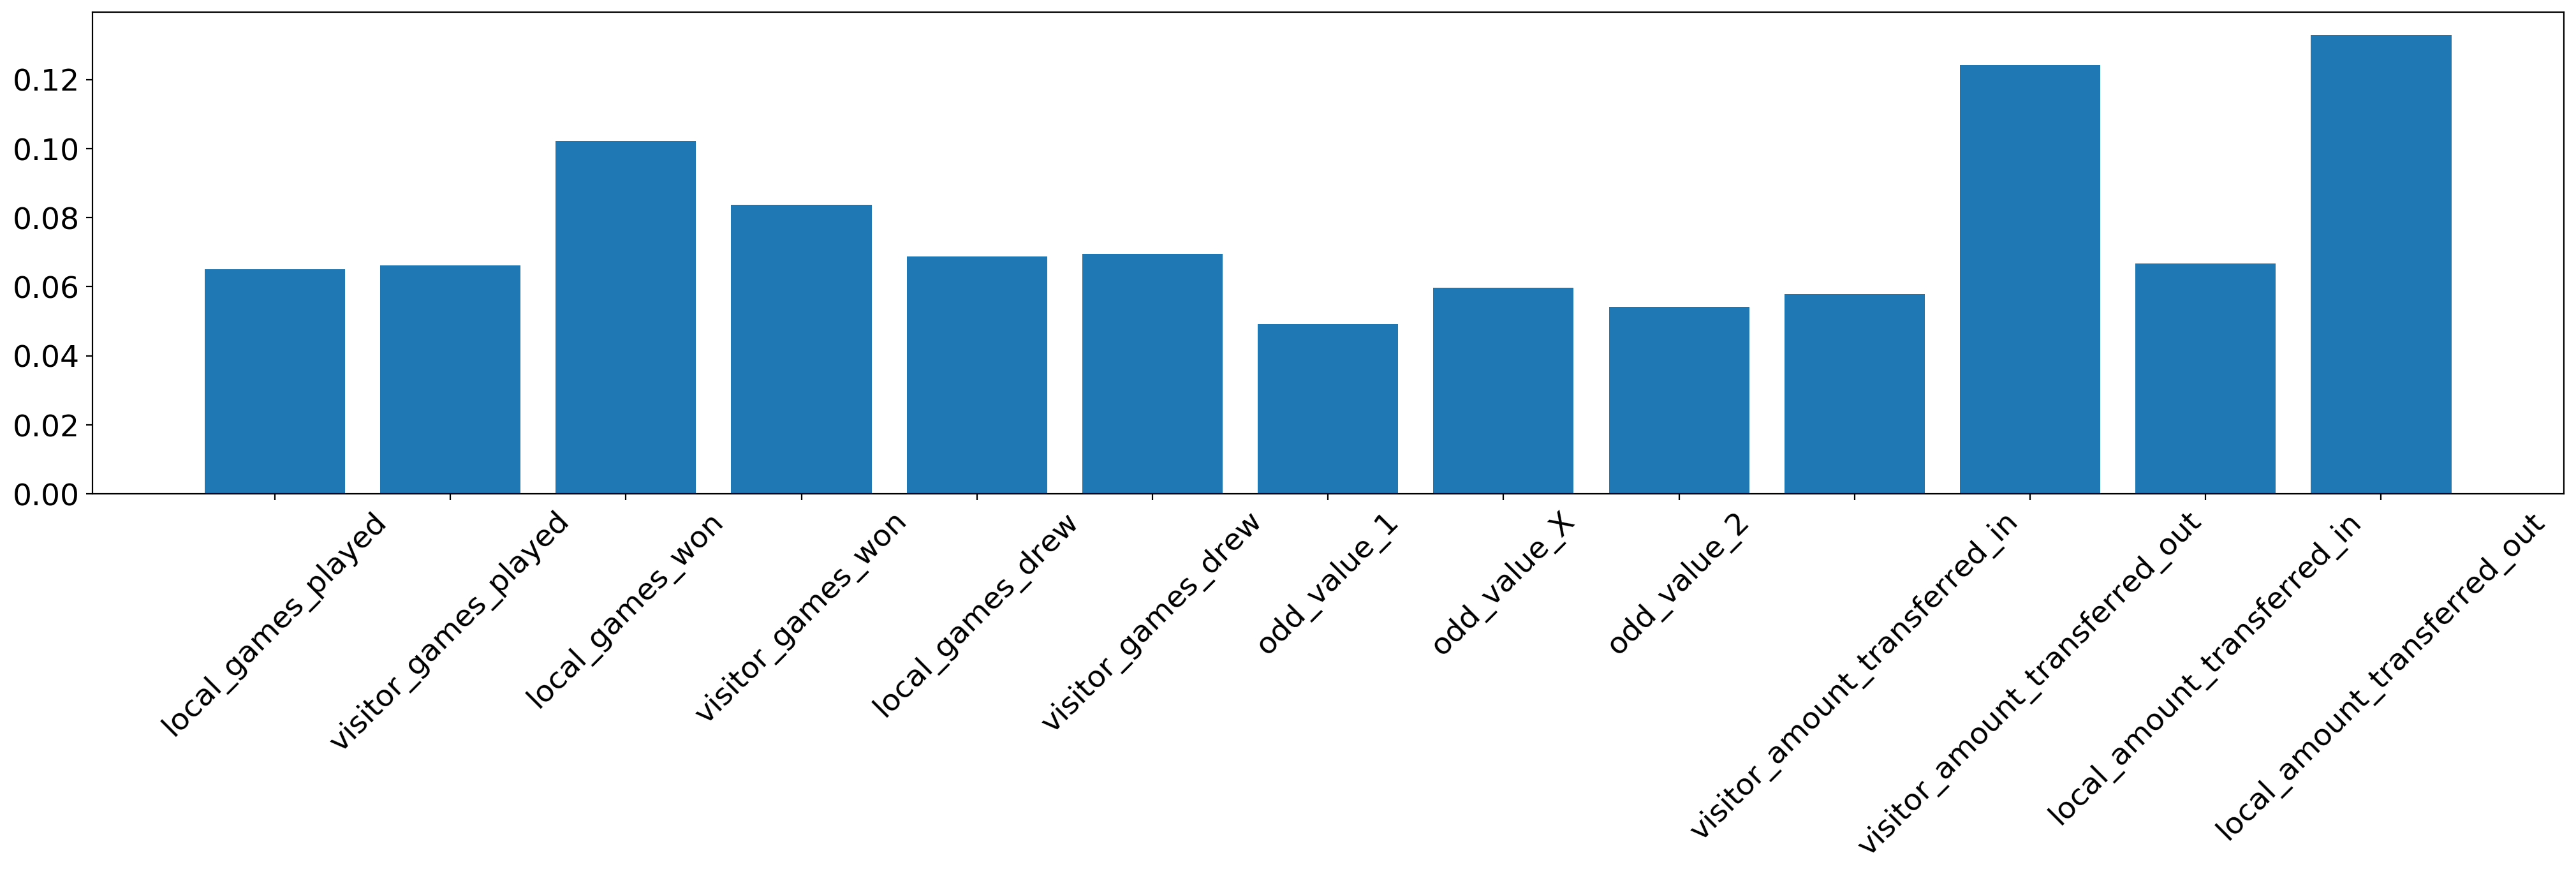

In [272]:
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(feature_names, model.feature_importances_)
plt.xticks(rotation=45)
plt.show()

In [273]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
        if i == 1:
            top_parameters = results['params'][candidate]
            
    return top_parameters   


space = {
    'learning_rate': (np.geomspace(1e-2, 1)),
    'max_depth': (range(1, 10)),
    'gamma': (np.geomspace(1e-2, 1)),
    'min_child_weight': (range(1, 10)),
    'n_estimators': (range(30, 300)),
    'reg_alpha': (np.linspace(0.2, 1)),
    'reg_lambda': (np.linspace(0.2, 2)),
}

random_search = RandomizedSearchCV(XGBClassifier(objective='multi:softmax', num_classes=3), param_distributions=space, n_iter=30)
random_search.fit(feature_matrix[feature_names], feature_matrix[target_name])

/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_classes=3,
       objective='multi:softmax', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=30, n_jobs=None,
          param_distributions={'learning_rate': array([0.01   , 0.01099, 0.01207, 0.01326, 0.01456, 0.016  , 0.01758,
       0.01931, 0.02121, 0.0233 , 0.0256 , 0.02812, 0.03089, 0.03393,
       0.03728, 0.04095, 0.04498, 0.04942, 0.05429, 0.05964, 0.06551,
       0.07197, 0.07906, 0.08685, 0.09541, 0.10481, ...39, 1.70612,
       1.74286, 1.77959, 1.81633, 1.85306, 1.8898 , 1.92653, 1.96327,
       2.     ])

In [275]:
top_parameters = report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.514 (std: 0.010)
Parameters: {'reg_lambda': 0.8244897959183675, 'reg_alpha': 0.8204081632653062, 'n_estimators': 91, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.010985411419875584, 'gamma': 0.025595479226995357}

Model with rank: 2
Mean validation score: 0.507 (std: 0.023)
Parameters: {'reg_lambda': 0.23673469387755103, 'reg_alpha': 0.689795918367347, 'n_estimators': 139, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.012067926406393288, 'gamma': 0.9102981779915218}

Model with rank: 3
Mean validation score: 0.505 (std: 0.027)
Parameters: {'reg_lambda': 1.0816326530612246, 'reg_alpha': 0.8367346938775511, 'n_estimators': 242, 'min_child_weight': 8, 'max_depth': 1, 'learning_rate': 0.3906939937054615, 'gamma': 0.9102981779915218}



In [ ]:
#top_parameters = {'reg_lambda': 0.8244897959183675, 'reg_alpha': 0.8204081632653062, 'n_estimators': 91, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.010985411419875584, 'gamma': 0.025595479226995357}

## Betting

In [276]:
features_with_odds = feature_matrix.dropna(subset=['odd_value_X'])
print(features_with_odds.shape)
features_with_odds.head()

(380, 55)


,localteam_id,date,Unnamed: 0,aggregate_id,assistants,attendance,coaches,colors,commentaries,deleted,...,local_games_played,local_games_won,local_games_drew,visitor_games_played,visitor_games_won,visitor_games_drew,visitor_amount_transferred_in,visitor_amount_transferred_out,local_amount_transferred_in,local_amount_transferred_out
76,36,2018-08-18,1526,NaN,"{'first_assistant_id': 18790, 'second_assistan...",16215.0,"{'localteam_coach_id': 896755, 'visitorteam_co...","{'localteam': {'color': None, 'kit_colors': No...",True,False,...,152.0,56.0,37.0,152.0,52.0,41.0,20000000.0,25800000.0,31500000.0,31500000.0
77,36,2018-09-01,1589,NaN,"{'first_assistant_id': 11711, 'second_assistan...",19013.0,"{'localteam_coach_id': 896755, 'visitorteam_co...","{'localteam': {'color': None, 'kit_colors': No...",True,False,...,154.0,57.0,38.0,154.0,98.0,33.0,21000000.0,89500000.0,31500000.0,31500000.0
78,36,2018-09-22,1643,NaN,"{'first_assistant_id': 16863, 'second_assistan...",16552.0,"{'localteam_coach_id': 896755, 'visitorteam_co...",NaN,True,False,...,156.0,58.0,38.0,4.0,0.0,2.0,0.0,0.0,31500000.0,31500000.0
79,36,2018-10-01,1724,NaN,"{'first_assistant_id': 12143, 'second_assistan...",14330.0,"{'localteam_coach_id': 896755, 'visitorteam_co...","{'localteam': {'color': None, 'kit_colors': No...",True,False,...,158.0,58.0,40.0,120.0,36.0,28.0,0.0,3000000.0,31500000.0,31500000.0
80,36,2018-10-19,1757,NaN,"{'first_assistant_id': 15300, 'second_assistan...",15627.0,"{'localteam_coach_id': 896755, 'visitorteam_co...","{'localteam': {'color': None, 'kit_colors': No...",True,False,...,160.0,58.0,41.0,84.0,33.0,17.0,9000000.0,9000000.0,31500000.0,31500000.0


In [277]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)
last_training_date = features_with_odds['date'].min()
features_training = feature_matrix.loc[feature_matrix['date'] < last_training_date]
xgb.fit(features_training[feature_names], features_training[target_name])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.025595479226995357,
       learning_rate=0.010985411419875584, max_delta_step=0, max_depth=4,
       min_child_weight=4, missing=None, n_estimators=91, n_jobs=1,
       nthread=None, num_classes=3, objective='multi:softprob',
       random_state=0, reg_alpha=0.8204081632653062,
       reg_lambda=0.8244897959183675, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

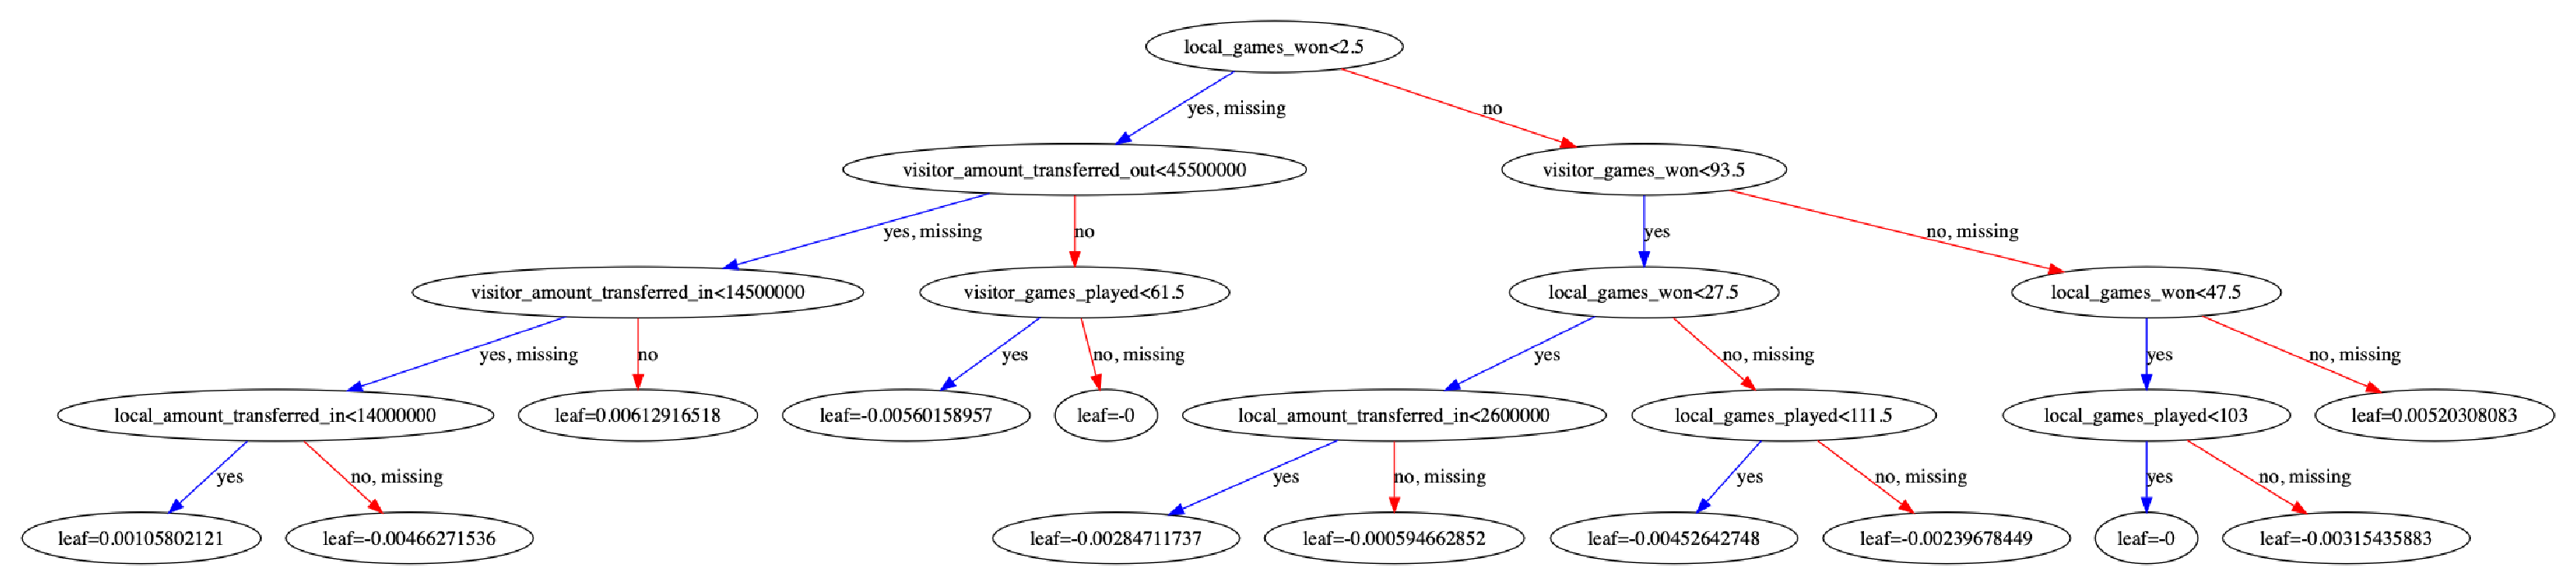

In [283]:
fig, ax = plt.subplots(figsize=(20, 50))
plot_tree(xgb, ax=ax, num_trees=1)

In [287]:
def xgboost_predict(features, model):
    predictions = model.predict_proba(features_single_date[feature_names])
    return predictions


def highest_odd(features, model):
    predictions = model.predict_proba(features_single_date[feature_names])
    return predictions


def get_bets_and_expected_gains(expected_value):
    bets = []
    for index, row in expected_value.iterrows():
        max_value = row.max()
        max_name = row.idxmax()
        bet = (row * 0).to_dict()
        bet[max_name] = max_value if max_value > 1 else 0
        bets.append(bet)
    
    bets = pd.DataFrame(bets)
    bets.columns = ['bet_1', 'bet_2', 'bet_X']
    return bets, bets

def get_results(target):
    categories = [0, 1, 2]
    results = pd.get_dummies(target).reset_index(drop=True)
    results = results.T.reindex(categories).T.fillna(0)
    return results
    
def get_returns(results, bets, odds):
    returns = pd.DataFrame(results.values * bets.values * odds.values, columns=results.columns)
    return returns

returns_over_time = []
for date in sorted(features_with_odds['date'].unique()):
    features_training = feature_matrix.loc[feature_matrix['date'] <= date]
    xgb.fit(features_training[feature_names], features_training[target_name])
    features_single_date = features_with_odds.loc[features_with_odds['date'] == date]
    odds = features_single_date[['odd_value_1', 'odd_value_X', 'odd_value_2']]
    predictions = xgboost_predict(features_single_date[feature_names], xgb)
    expected_value = odds * predictions
    bets, expected_gains = get_bets_and_expected_gains(expected_value)
    money_in_play = bets.sum().sum()
    results = get_results(features_single_date[target_name])
    returns = get_returns(results, bets, odds)
    total_returns_single_date = returns.sum().sum() - money_in_play
    returns_over_time.append(total_returns_single_date)
    
returns_over_time = pd.Series(returns_over_time, index=sorted(features_with_odds['date'].unique())).sort_index()

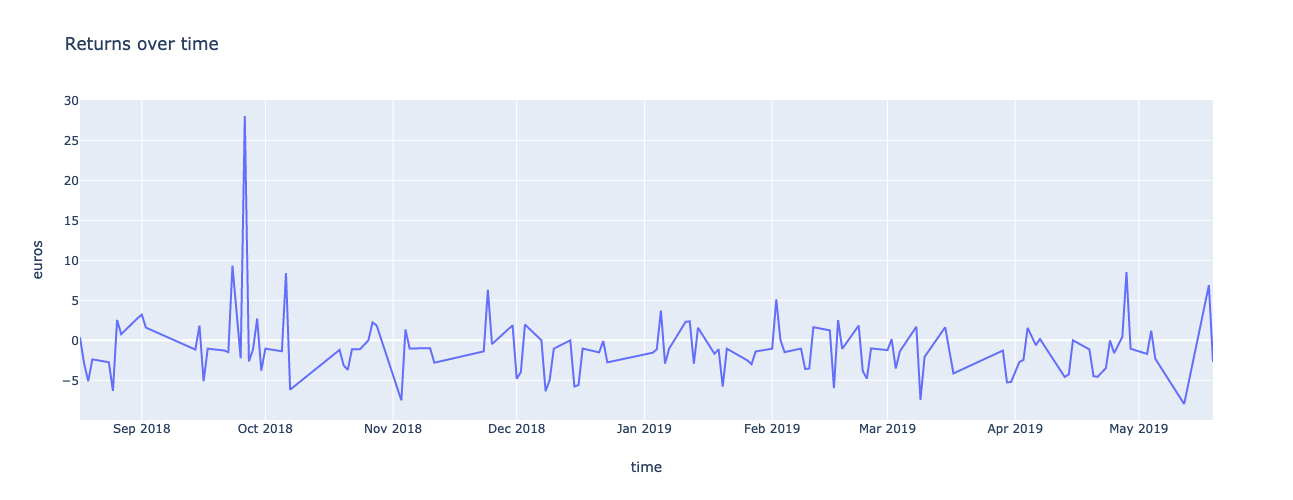

In [289]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

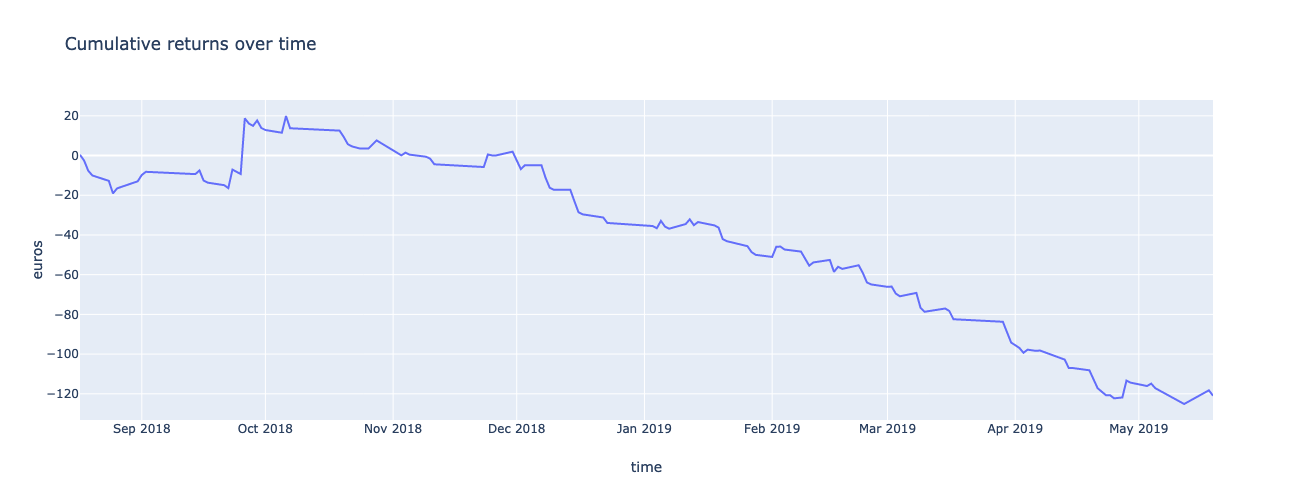

In [290]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.cumsum().values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Cumulative returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

Total returns after 129 betting days: -120.95689196516571


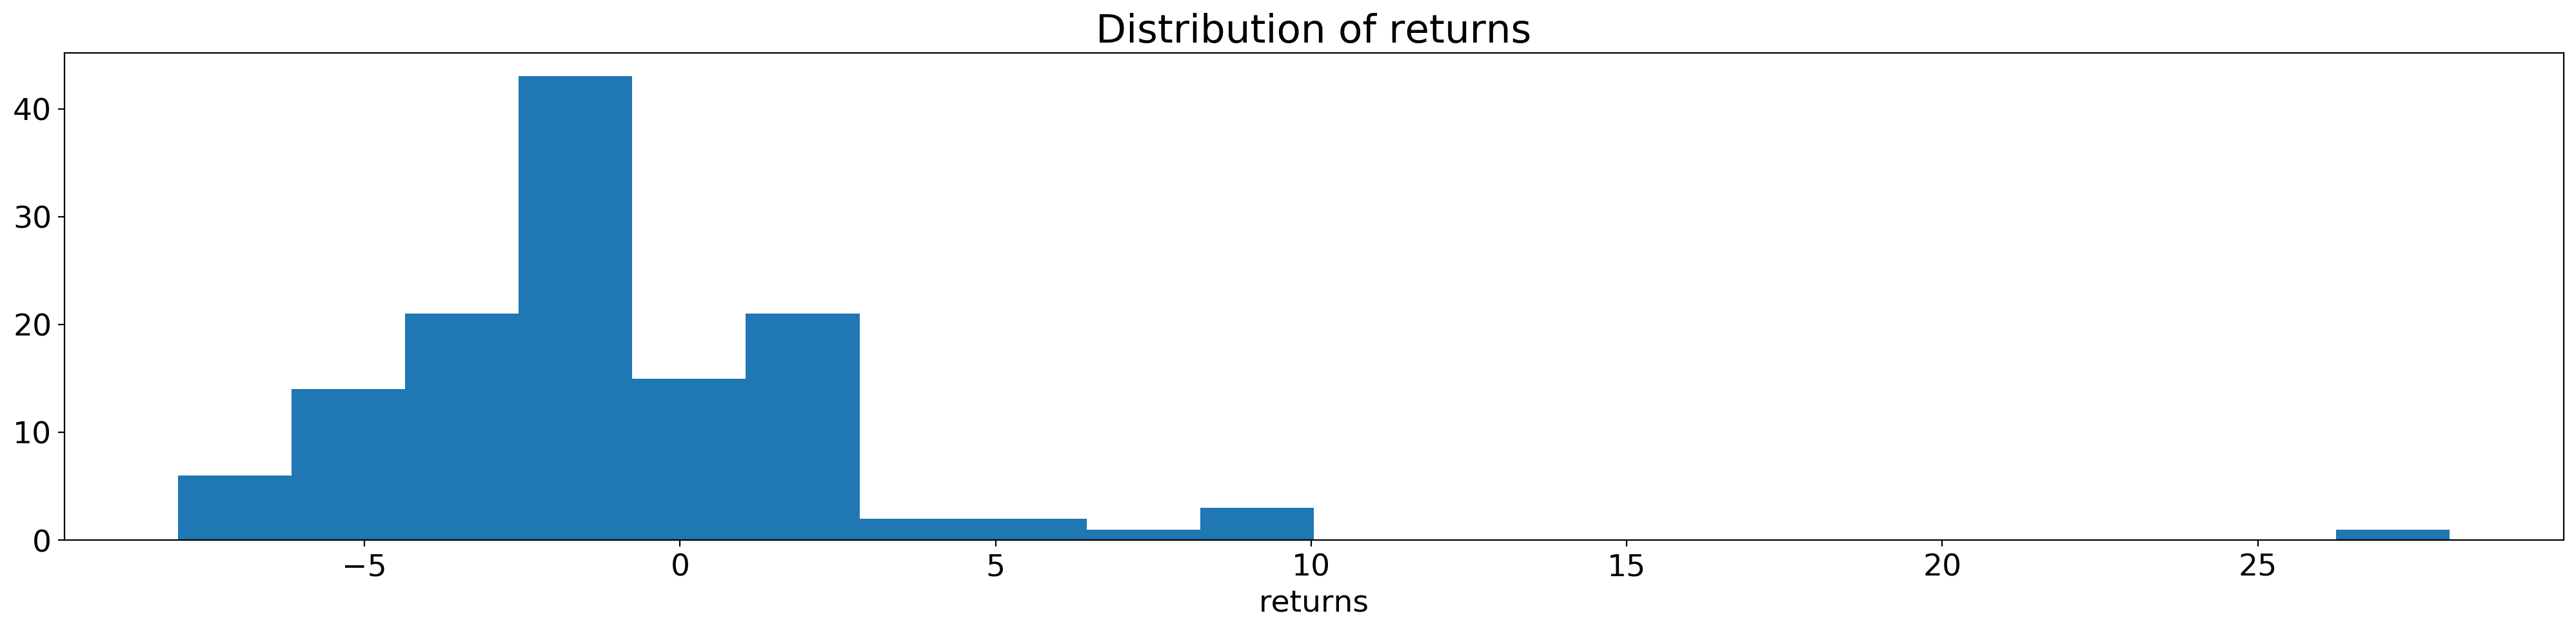

In [291]:
print(f'Total returns after {features_with_odds.date.nunique()} betting days: {np.sum(returns_over_time)}')
fig, ax = plt.subplots(figsize=(25, 5))
ax.hist(returns_over_time, bins=20)
ax.set_title('Distribution of returns')
ax.set_xlabel('returns')
plt.show()